# MNIST with ConvNets

> <span style="color:gray">
Original [Theano/Lasagne tutorial](https://github.com/DeepLearningDTU/nvidia_deep_learning_summercamp_2016/blob/master/lab1/lab1_FFN.ipynb) by 
Lars Maaløe ([larsmaaloee](https://github.com/larsmaaloee)),
Søren Kaae Sønderby ([skaae](https://github.com/skaae)), and 
Casper Sønderby ([casperkaae](https://github.com/casperkaae)). 
Converted to TensorFlow by 
Alexander R. Johansen ([alrojo](https://github.com/alrojo)), 
and updated by 
Toke Faurby ([faur](https://github.com/Faur)).
</span>


In this lab we will solve the MNIST problem again, but this time with convolutional networks.
You will get a to try stacking of convolutional layers, max pooling and strided convolutions which are all important techniques in current convolutional layers network architectures.


### Dependancies and supporting functions


Loading dependancies and supporting functions by running the code block below.

In [1]:
from __future__ import absolute_import, division, print_function 

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# import sklearn.datasets
import tensorflow as tf
import os
import sys
sys.path.append(os.path.join('.', '..')) 
import utils 


## The MNIST data set

We load the MNIST dataset.
This time the data is keept as images (`shape = [28, 28, 1]`), and not flattended into vectors (`shape = [784]`).
This allows the convolutional network to take advantage of the structure of the data

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz

Information on dataset
    ----------------------
Training size:	 55000
Test size	 10000
Validation size	 5000

Data summaries
Image shape		 (28, 28, 1)
Image type		 <class 'numpy.ndarray'>
Image min/max value	 0.0 / 1.0
Label shape		 (10,)
Label type		 <class 'numpy.float64'>


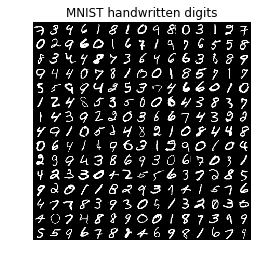

In [2]:
# Load data (download if you haven't already)
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('MNIST_data', 
                                       one_hot=True,   # Convert the labels into one hot encoding
                                       dtype='float32', # rescale images to `[0, 1]`
                                       reshape=False, # Don't flatten the images to vectors
                                      )

## Print dataset statistics and visualize
print('')
utils.mnist_summary(mnist_data)

## Building the model

We will use Keras layers, which are documented [here](https://keras.io/layers/about-keras-layers/)

In [3]:
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D
from tensorflow.contrib.layers import flatten # We use this flatten, as it works better than 
                                              # the Keras 'Flatten' for some reason


Using TensorFlow backend.


In [4]:
tf.reset_default_graph()

num_classes = 10
height, width, nchannels = 28, 28, 1
padding = 'same'

filters_1 = 16
kernel_size_1 = (5,5)
pool_size_1 = (2,2)

x_pl = tf.placeholder(tf.float32, [None, height, width, nchannels], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, num_classes], name='yPlaceholder')
y_pl = tf.cast(y_pl, tf.float32)

print('Trace of the tensors shape as it is propagated through the network.')
print('Layer name \t Output size')
print('----------------------------')

with tf.variable_scope('convLayer1'):
    conv1 = Conv2D(filters_1, kernel_size_1, strides=(1,1), padding=padding, activation='relu')
    print('x_pl \t\t', x_pl.get_shape())
    x = conv1(x_pl)
    print('conv1 \t\t', x.get_shape())

    pool1 = MaxPooling2D(pool_size=pool_size_1, strides=None, padding=padding)
    x = pool1(x)
    print('pool1 \t\t', x.get_shape())
    x = flatten(x)
    print('Flatten \t', x.get_shape())


with tf.variable_scope('output_layer'):
    denseOut = Dense(units=num_classes, activation='softmax')
    
    y = denseOut(x)
    print('denseOut\t', y.get_shape())    

print('Model consits of ', utils.num_params(), 'trainable parameters.')

Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size
----------------------------
x_pl 		 (?, 28, 28, 1)
conv1 		 (?, 28, 28, 16)
pool1 		 (?, 14, 14, 16)
Flatten 	 (?, 3136)
denseOut	 (?, 10)
Model consits of  31786 trainable parameters.


In [5]:
## Launch TensorBoard, and visualize the TF graph
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.45)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    tmp_def = utils.rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
    utils.show_graph(tmp_def)

In [6]:
with tf.variable_scope('loss'):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(y+1e-8), reduction_indices=[1])

    # averaging over samples
    cross_entropy = tf.reduce_mean(cross_entropy)

    
with tf.variable_scope('training'):
    # defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

    # applying the gradients
    train_op = optimizer.minimize(cross_entropy)

    
with tf.variable_scope('performance'):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pl, axis=1))

    # averaging the one-hot encoded vector
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [7]:
#Test the forward pass
x_batch, y_batch = mnist_data.train.next_batch(4)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
# with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    y_pred = sess.run(fetches=y, feed_dict={x_pl: x_batch})

assert y_pred.shape == y_batch.shape, "ERROR the output shape is not as expected!" \
        + " Output shape should be " + str(y.shape) + ' but was ' + str(y_pred.shape)

print('Forward pass successful!')

Forward pass successful!


## Training

In [13]:
#Training Loop
batch_size = 100
max_epochs = 10

valid_loss, valid_accuracy = [], []
train_loss, train_accuracy = [], []
test_loss, test_accuracy = [], []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('Begin training loop')

    try:
        while mnist_data.train.epochs_completed < max_epochs:
            _train_loss, _train_accuracy = [], []
            
            ## Run train op
            x_batch, y_batch = mnist_data.train.next_batch(batch_size)
            fetches_train = [train_op, cross_entropy, accuracy]
            feed_dict_train = {x_pl: x_batch, y_pl: y_batch}
            _, _loss, _acc = sess.run(fetches_train, feed_dict_train)
            
            _train_loss.append(_loss)
            _train_accuracy.append(_acc)
            

            ## Compute validation loss and accuracy
            if mnist_data.train.epochs_completed % 1 == 0 \
                    and mnist_data.train._index_in_epoch <= batch_size:
                train_loss.append(np.mean(_train_loss))
                train_accuracy.append(np.mean(_train_accuracy))

                fetches_valid = [cross_entropy, accuracy]
                
                feed_dict_valid = {x_pl: mnist_data.validation.images, y_pl: mnist_data.validation.labels}
                _loss, _acc = sess.run(fetches_valid, feed_dict_valid)
                
                valid_loss.append(_loss)
                valid_accuracy.append(_acc)
                print("Epoch {} : Train Loss {:6.3f}, Train acc {:6.3f},  Valid loss {:6.3f},  Valid acc {:6.3f}".format(
                    mnist_data.train.epochs_completed, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
        
        
        test_epoch = mnist_data.test.epochs_completed
        while mnist_data.test.epochs_completed == test_epoch:
            x_batch, y_batch = mnist_data.test.next_batch(batch_size)
            feed_dict_test = {x_pl: x_batch, y_pl: y_batch}
            _loss, _acc = sess.run(fetches_valid, feed_dict_test)
            test_loss.append(_loss)
            test_accuracy.append(_acc)
        print('Test Loss {:6.3f}, Test acc {:6.3f}'.format(
                    np.mean(test_loss), np.mean(test_accuracy)))


    except KeyboardInterrupt:
        pass


Begin training loop
Epoch 11 : Train Loss  0.031, Train acc  0.969,  Valid loss  0.073,  Valid acc  0.978
Epoch 12 : Train Loss  0.026, Train acc  1.000,  Valid loss  0.057,  Valid acc  0.983
Epoch 13 : Train Loss  0.027, Train acc  1.000,  Valid loss  0.058,  Valid acc  0.984
Epoch 14 : Train Loss  0.059, Train acc  0.969,  Valid loss  0.051,  Valid acc  0.986
Epoch 15 : Train Loss  0.036, Train acc  1.000,  Valid loss  0.050,  Valid acc  0.987
Epoch 16 : Train Loss  0.009, Train acc  1.000,  Valid loss  0.052,  Valid acc  0.986
Epoch 17 : Train Loss  0.001, Train acc  1.000,  Valid loss  0.051,  Valid acc  0.986
Epoch 18 : Train Loss  0.000, Train acc  1.000,  Valid loss  0.053,  Valid acc  0.985
Epoch 19 : Train Loss  0.014, Train acc  1.000,  Valid loss  0.054,  Valid acc  0.987
Epoch 20 : Train Loss  0.003, Train acc  1.000,  Valid loss  0.052,  Valid acc  0.986
Test Loss  0.047, Test acc  0.987


(<matplotlib.text.Text at 0x2308d5df7f0>,
 (0.75, 1.03))

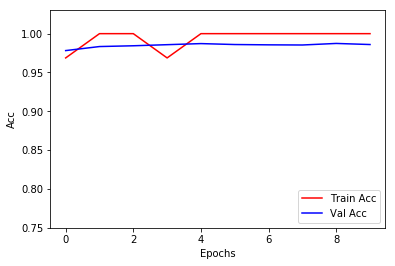

In [14]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_accuracy,'r', epoch, valid_accuracy,'b')
plt.legend(['Train Acc','Val Acc'], loc=4)
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0.75,1.03])

## Keras

In [19]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten
from keras.optimizers import Adam

In [28]:
model = Sequential()
# input: (28, 28, 1)
# this applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, nchannels)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
#model.add(flatten(model.layers[3].output)[0]) 
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# softmax activation, one-hot encoded target with categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [29]:
history = model.fit(mnist_data.train.images, mnist_data.train.labels, batch_size=32, epochs=10)

Epoch 1/10
55000/55000 [==============================] - 13s - loss: 0.1681 - acc: 0.9478    
Epoch 2/10
55000/55000 [==============================] - 12s - loss: 0.0587 - acc: 0.9820    
Epoch 3/10
55000/55000 [==============================] - 12s - loss: 0.0440 - acc: 0.9864    
Epoch 4/10
55000/55000 [==============================] - 12s - loss: 0.0349 - acc: 0.9893    
Epoch 5/10
55000/55000 [==============================] - 12s - loss: 0.0304 - acc: 0.9907    
Epoch 6/10
55000/55000 [==============================] - 12s - loss: 0.0253 - acc: 0.9921    
Epoch 7/10
55000/55000 [==============================] - 12s - loss: 0.0239 - acc: 0.9927    
Epoch 8/10
55000/55000 [==============================] - 12s - loss: 0.0206 - acc: 0.9941    
Epoch 9/10
55000/55000 [==============================] - 12s - loss: 0.0202 - acc: 0.9939    
Epoch 10/10
 9824/10000 [============================>.] - ETA: 0s

In [63]:
score, acc = model.evaluate(mnist_data.test.images, mnist_data.test.labels)

10000/10000 [==============================] - 0s     


In [64]:
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.0203816208113
Test accuracy: 0.9944


In [73]:
for i in range(0, 1000):
    res = model.predict(np.reshape(mnist_data.test.images[i], (1, 28, 28, 1)))
    if np.argmax(mnist_data.test.labels[i]) != np.argmax(res):
        print(i)

450
582
740
947


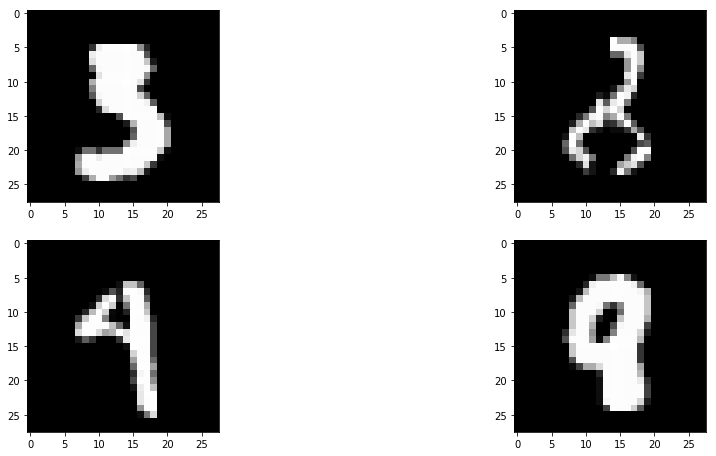

In [75]:
fig = plt.figure(figsize=(16,12))
image = mnist_data.test.images[450]
fig.add_subplot(321)    
plt.imshow(np.reshape(image,[28,28]), interpolation="nearest", cmap="gray")

image = mnist_data.test.images[582]
fig.add_subplot(322)    
plt.imshow(np.reshape(image,[28,28]), interpolation="nearest", cmap="gray")

image = mnist_data.test.images[740]
fig.add_subplot(323)    
plt.imshow(np.reshape(image,[28,28]), interpolation="nearest", cmap="gray")

image = mnist_data.test.images[947]
fig.add_subplot(324)    
plt.imshow(np.reshape(image,[28,28]), interpolation="nearest", cmap="gray")

In [74]:
for i in [450, 582, 740, 947]:
    res = model.predict(np.reshape(mnist_data.test.images[i], (1, 28, 28, 1)))
    print("Network output = {}. True output {}".format(np.argmax(res), np.argmax(mnist_data.test.labels[i])))

Network output = 5. True output 3
Network output = 2. True output 8
Network output = 9. True output 4
Network output = 9. True output 8


In [77]:
prediction = model.predict(np.reshape(mnist_data.test.images[740], (1, 28, 28, 1)))
print(prediction)

[[  3.79957896e-07   2.25197946e-05   4.21868572e-05   3.11141548e-06
    3.16704869e-01   2.60895922e-06   1.19775484e-06   1.43174641e-03
    5.81515837e-04   6.81209922e-01]]


# Assignments

## <span style="color:red"> EXE 1.1 </span> Manual calculations

![](images/conv_exe.png)



1. Manually convolve the input, and compute the convolved features. No padding and no strieds.
1. Perform `2x2` max pooling on the convolved features. Stride of 2.

___

<span style="color:blue"> Answer: </span>






## <span style="color:red"> EXE 1.2 </span> Reducing the resolution
One of the important features of convolutional networks are their ability to reduce the spatial resolution, while retaining the important features.
Effectively this gives a local translational invariance and reduces the computation. 
This is most often done with **maxpooling** or by using strides.

1. Using only convolutional layers and pooling operations reduce the feature map size to `1x1xF`.
    * The number of feature maps, `F`, is up to you.

___

<span style="color:blue"> Write down what you did: </span>

``` 
Paste your code here
```


``` 
Paste the trace of the tensors shape as it is propagated through the network here
```


## <span style="color:red"> EXE 1.3 </span> Play around with the network.
The MNIST dataset is so easy to solve with convolutional networks that it isn't interesting to spend to much time on maximizing performance.
A more interesting question is *how few parameters can you solve it with?*

1. Try and minimize the number of parameters, while keeping validation accuracy about 95%. Try changing the

    * Number of layers
    * Number of filters
    * Kernel size
    * Pooling size
1. Once happy take note of the performance, number of parameters (printed automatically), and describe the network below.
___


<span style="color:blue"> Answer: </span>


## <span style="color:red"> EXE 1.4 </span> Comparing dense and convolutional networks

1. Now create a densely connected network (the ones from lab 1), and see how good performance you can get with a similar number of parameters.
___

<span style="color:blue"> Describe your findings: </span>
